# Import libraries

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from tslearn.clustering import TimeSeriesKMeans

from sklearn.metrics import silhouette_score

from tqdm import tqdm

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', None)

# Loading data

In [3]:
path_to_data = './../data/ftir_scaled_train.csv'
path_to_description = './../data/ftir_description.csv'

## Scaled spectra

In [4]:
data_scaled = pd.read_csv(path_to_data, index_col=0)

print(data_scaled.shape)
data_scaled.head(3)

(26, 1142)


0            1            2            3            4  \
wavenumber  1900.766600  1899.802230  1898.837870  1897.873500  1896.909130   
1              0.000494     0.000944     0.001362     0.001750     0.002112   
2              0.000210     0.000215     0.000213     0.000205     0.000192   

                      5            6            7            8            9  \
wavenumber  1895.944770  1894.980400  1894.016030  1893.051670  1892.087300   
1              0.002451     0.002770     0.003074     0.003364     0.003646   
2              0.000175     0.000155     0.000132     0.000109     0.000085   

                     10           11           12           13           14  \
wavenumber  1891.122930  1890.158570  1889.194200  1888.229830  1887.265470   
1              0.003921     0.004193     0.004467     0.004744     0.005028   
2              0.000063     0.000042     0.000025     0.000011     0.000003   

                     15           16           17           18          19  \
wavenumber  1886.301100  1885.336730  1884.372370  1883.408000  1882.44364   
1              0.005324     0.005633     0.005960     0.006308     0.00668   
2              0.000000     0.000004     0.000017     0.000039     0.00007   

                     20           21           22           23           24  \
wavenumber  1881.479270  1880.514900  1879.550540  1878.586170  1877.621800   
1              0.007079     0.007509     0.007974     0.008476     0.009019   
2              0.000113     0.000168     0.000236     0.000318     0.000415   

            ...        1117        1118        1119        1120        1121  \
wavenumber  ...  823.569090  822.604720  821.640360  820.675990  819.711620   
1           ...    0.037121    0.035323    0.033560    0.031835    0.030152   
2           ...    0.072690    0.071565    0.070364    0.069083    0.067721   

                  1122        1123        1124        1125        1126  \
wavenumber  818.747260  817.782890  816.818520  815.854160  814.889790   
1             0.028514    0.026926    0.025390    0.023910    0.022491   
2             0.066275    0.064743    0.063123    0.061413    0.059610   

                  1127        1128        1129        1130        1131  \
wavenumber  813.925420  812.961060  811.996690  811.032320  810.067960   
1             0.021135    0.019846    0.018627    0.017483    0.016417   
2             0.057713    0.055719    0.053626    0.051432    0.049135   

                  1132        1133        1134        1135        1136  \
wavenumber  809.103590  808.139230  807.174860  806.210490  805.246130   
1             0.015433    0.014533    0.013723    0.013004    0.012382   
2             0.046732    0.044221    0.041600    0.038868    0.036021   

                  1137        1138        1139        1140        1141  
wavenumber  804.281760  803.317390  802.353030  801.388660  800.424290  
1             0.011859    0.011440    0.011127    0.010924    0.010836  
2             0.033058    0.029976    0.026773    0.023447    0.019997  

[3 rows x 1142 columns]

## Samples description

In [5]:
samples_description = pd.read_csv(path_to_description, index_col=0)

print(samples_description.shape)
samples_description.head(3)

(29, 4)


Description  Type  Class  Label
1                    MFGO, разб. 1:20  $GO$      1  Train
2           HGO, 0.0116 г в 25 мл H2O  $GO$      1  Train
3  GO, RusGraphene, 2 г в 1000 мл H2O  $GO$      1  Train

# Data wrangling

## Samples description

In [6]:
samples_description = (
    samples_description
    .loc[samples_description['Label'] == 'Train']
    .drop(columns=['Label'])
)

samples_description.index = samples_description.index.astype(str)

print(samples_description.shape)
samples_description.head(3)

(25, 3)


Description  Type  Class
1                    MFGO, разб. 1:20  $GO$      1
2           HGO, 0.0116 г в 25 мл H2O  $GO$      1
3  GO, RusGraphene, 2 г в 1000 мл H2O  $GO$      1

## Spectral data

In [7]:
wavenumber = data_scaled.iloc[0]
data = data_scaled.iloc[1:, :]

# selecting only go data
go_indexes = samples_description.loc[samples_description['Type'] == '$GO$'].index
go_data = data.loc[go_indexes]

# selecting only go dialysis data
god_indexes = samples_description.loc[samples_description['Type'] == '$GO_{d}$'].index
god_data = data.loc[god_indexes]

# selecting only rgo data
rgo_indexes = samples_description.loc[samples_description['Type'] == '$rGO$'].index
rgo_data = data.loc[rgo_indexes]

## Base variables

In [8]:
type_color_dict = {
    '$GO$': 'RoyalBlue',
    '$rGO$': 'Goldenrod',
    '$GO_{d}$': 'SeaGreen'
}

In [9]:
FONT_SIZE_TITLE = 22
FONT_SIZE_XLABEL = 18
FONT_SIZE_YLABEL = 18
FONT_SIZE_XTICKS = 16
FONT_SIZE_YTICKS = 16

# Clustering

## Class for clustering

In [10]:
class ClusterStructureAnalysis:
    def __init__(self, metric='euclidean'):
        self.metric = metric

    def fit_transform_ts_kmeans(self, train_data, n_clusters, n_jobs=-1, max_iter=100_000, random_state=42):
        n_clusters = min(n_clusters, len(train_data) - 1)
        estimator = TimeSeriesKMeans(n_clusters=n_clusters, metric=self.metric, n_jobs=n_jobs, max_iter=max_iter, random_state=random_state)
        estimator.fit(train_data)

        self.train_data = train_data
        self.n_clusters = len(estimator.cluster_centers_)
        self.estimator = estimator
        self.inertia = estimator.inertia_
        self.cluster_centers = estimator.cluster_centers_[:, :, 0]

        predictions = pd.DataFrame(estimator.predict(train_data), index=train_data.index, columns=['Prediction'])
        self.predictions = predictions['Prediction']
        self.train_data_predictions = pd.concat([train_data, predictions], axis=1).sort_values(by='Prediction', ascending=True)

    def get_silhouette_score(self):
        if self.n_clusters < 2 or self.n_clusters >= len(self.train_data):
            return None
        return silhouette_score(self.train_data, self.estimator.labels_)

    def get_metrics_visualization(self, train_data, max_n_clusters, ax):
        n_clusters_arr = list(range(2, min(max_n_clusters, len(train_data) - 1) + 1))
        metric_values = []

        for n_clusters in tqdm(n_clusters_arr):
            self.fit_transform_ts_kmeans(train_data=train_data, n_clusters=n_clusters)
            score = self.get_silhouette_score()
            metric_values.append(score if score is not None else 0)
        
        sns.barplot(
            x=n_clusters_arr,
            y=metric_values,
            palette='viridis',
            ax=ax
        )

        ax.set_title('Зависимость silhouette score от числа кластеров', fontsize=FONT_SIZE_TITLE)
        
        ax.set_xlabel('Число кластеров', fontsize=FONT_SIZE_XLABEL)
        ax.set_ylabel('Silhouette score', fontsize=FONT_SIZE_YLABEL)
    
        ax.tick_params(axis='x', labelsize=FONT_SIZE_XTICKS)
        ax.tick_params(axis='y', labelsize=FONT_SIZE_YTICKS)
        
        ax.grid(True)

    def get_spectra_clusters_visualization(self, data, wavenumber, n_clusters, axes, color):
        self.fit_transform_ts_kmeans(train_data=data, n_clusters=n_clusters)
        
        n_clusters = self.n_clusters
        data_with_labels = self.train_data_predictions
        centroids = self.cluster_centers

        for cluster_id in range(n_clusters):
            ax = axes[cluster_id]
            temp_data = data_with_labels[data_with_labels['Prediction'] == cluster_id].iloc[:, :-1].to_numpy()
            temp_centroid = centroids[cluster_id]

            for spectrum in temp_data:
                ax.plot(wavenumber, spectrum, linewidth=3.5, color=color, alpha=1.0)
            ax.plot(wavenumber, temp_centroid, linestyle='--', linewidth=4.0, color='black', alpha=0.7)

            ax.set_title(f'Кластер №{cluster_id+1}', fontsize=FONT_SIZE_TITLE-4, fontweight='bold')
            
            ax.set_xlabel('Волновое число, см$^{-1}$', fontsize=FONT_SIZE_XLABEL)  # Wavenumber, cm$^{-1}
            ax.set_ylabel('$A_{n}$', fontsize=FONT_SIZE_YLABEL, rotation=0, labelpad=20)

            ax.set_xticks(np.linspace(1900, 800, 6))
            
            ax.tick_params(axis='x', labelsize=FONT_SIZE_XTICKS)
            ax.tick_params(axis='y', labelsize=FONT_SIZE_YTICKS)
            
            ax.invert_xaxis()

## Metric — Euclidean distance

### Clustering & Visualization

In [11]:
n_datasets = 3  
max_n_clusters = 10  

datasets = [
    ('$ОГ$', go_data, 'RoyalBlue', 4),
    ('$вОГ$', rgo_data, 'Goldenrod', 2),
    ('$ОГ_{диализ}$', god_data, 'SeaGreen', 5)
]

predictions_lst = []

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 31.55it/s]


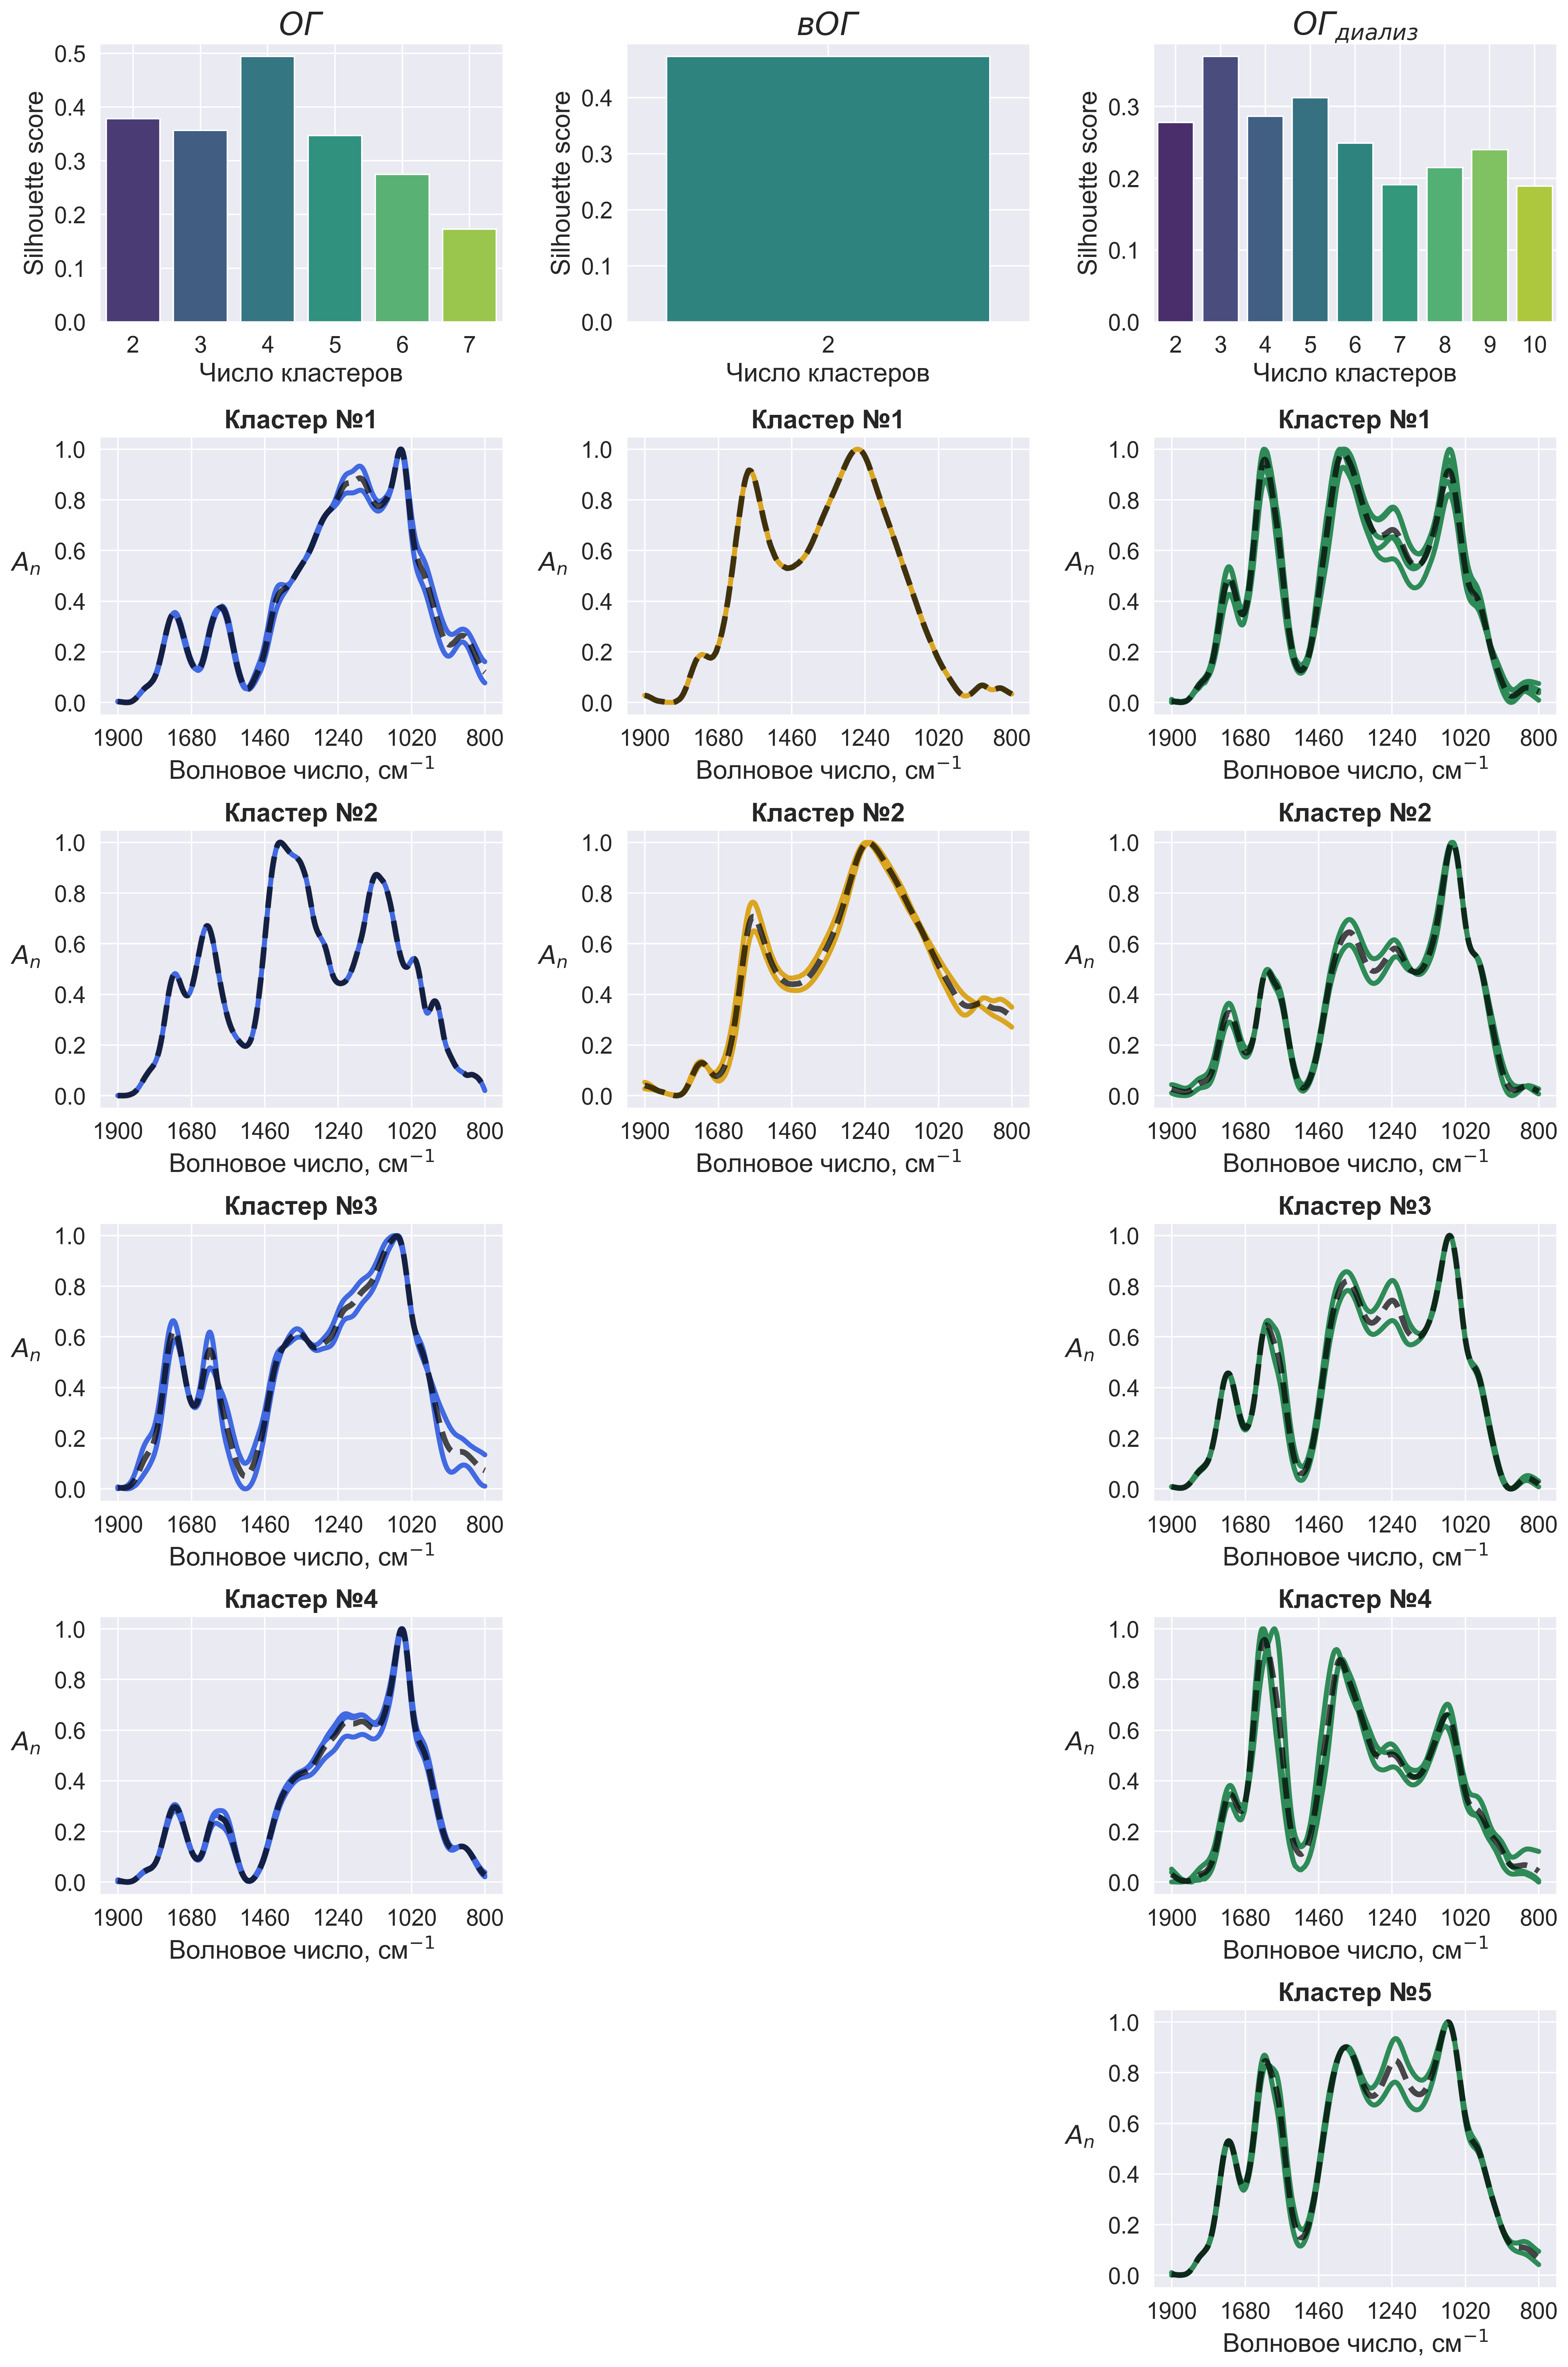

In [12]:
sns.set_theme()

max_clusters = max([d[3] for d in datasets])
fig_rows = 1 + max_clusters 

fig, axes = plt.subplots(fig_rows, 3, figsize=(15.5, 3.85 * fig_rows), dpi=300, constrained_layout=True)  

for i, (label, dataset, color, n_clusters) in enumerate(datasets):
    analyzer = ClusterStructureAnalysis(metric='euclidean')

    analyzer.get_metrics_visualization(train_data=dataset, max_n_clusters=max_n_clusters, ax=axes[0, i])
    axes[0, i].set_title(f'{label}', fontsize=FONT_SIZE_TITLE)

    sub_axes = axes[1:n_clusters+1, i]
    analyzer.get_spectra_clusters_visualization(data=dataset, wavenumber=wavenumber, n_clusters=n_clusters, axes=sub_axes, color=color)

    predictions_lst.append(analyzer.train_data_predictions)

for i in range(3):  
    for j in range(datasets[i][3] + 1, fig_rows):  
        axes[j, i].axis("off")

plt.tight_layout()

plt.savefig('./../results/01a_as_timeseries/euclidean/clustering_results.png', dpi=600)

plt.show()

### Analytics of results

In [13]:
results_df = pd.DataFrame()

for predictions_df in predictions_lst:
    tmp_description_prediction_df = pd.merge(
        left=predictions_df['Prediction'],
        right=samples_description[['Type', 'Description']],
        left_index=True,
        right_index=True
    )

    results_df = pd.concat([results_df, tmp_description_prediction_df], axis=0)

results_df = results_df[['Type', 'Description', 'Prediction']].sort_values(by=['Type', 'Prediction', 'Description'])

results_df

Type  \
3       $GO$   
13      $GO$   
2       $GO$   
12      $GO$   
1       $GO$   
9       $GO$   
11      $GO$   
8       $GO$   
20  $GO_{d}$   
19  $GO_{d}$   
24  $GO_{d}$   
23  $GO_{d}$   
28  $GO_{d}$   
26  $GO_{d}$   
18  $GO_{d}$   
27  $GO_{d}$   
17  $GO_{d}$   
30  $GO_{d}$   
25  $GO_{d}$   
29  $GO_{d}$   
31  $GO_{d}$   
22  $GO_{d}$   
10     $rGO$   
6      $rGO$   
21     $rGO$   

                                                                                  Description  \
3                                                          GO, RusGraphene, 2 г в 1000 мл H2O   
13                                                         GO, RusGraphene, 2 г в 1000 мл H2O   
2                                                                   HGO, 0.0116 г в 25 мл H2O   
12                                                                GO, USA, 0.1 г в 100 мл H2O   
1                                                                            MFGO, разб. 1:20   
9                                                        GO, RusGraphene, 1.00 г в 250 мл H2O   
11                                                       GO, RusGraphene, 1.00 г в 250 мл H2O   
8                                                          GO, RusGraphene, 2 г в 1000 мл H2O   
20                                Образец 8 после диализа 3.5 кДа, конд. 7 дней в ЭДТА 0.05 М   
19                                     Образец 8 после диализа, конд. 7 дней в H2O (14.0 кДа)   
24                            Образец 9 после диализа 14 кДа 75 мм, конд. 7 дней в ЭДТА 0.05М   
23                                  Образец 9 после диализа 14 кДа, конд. 7 дней в ЭДТА 0.05М   
28                         Образец 9 после диализа при 25°С 14 кДа, конд. 7 дней в ЭДТА 0.05М   
26                                              Образец 11 после диализа 2 дня, H2O (1.0 кДа)   
18        Образец 8 после диализа 7 дней, H2O, стакан 1 л, замена воды каждые 2 дня (0.5 кДа)   
27                                      Образец 11 после диализа 5 дней, H2O, 75 мм (3.5 кДа)   
17        Образец 8 после диализа 7 дней, H2O, стакан 1 л, замена воды каждые 2 дня (3.5 кДа)   
30                                Образец 13 после диализа 0.5 кДа, конд. 7 дней в ЭДТА 0.05М   
25  Образец 9 после диализа 14 кДа 75 мм, конд. 7 дней в ЭДТА 0.05М (повторное использование)   
29                         Образец 9 после диализа при 45°С 14 кДа, конд. 7 дней в ЭДТА 0.05М   
31                        Образец 30 после диализа 12 дней, 14 кДа, конд. 7 дней в ЭДТА 0.05М   
22      Образец 8 после диализа 3.5 кДа, конд. 7 дней в ЭДТА 0.05 М (повторное использование)   
10                                                      rGO, RusGraphene, 0.20 г в 100 мл H2O   
6                                                         rGO, RusGraphene, 2 г в 1000 мл H2O   
21                                                    Образец 10 после диализа 3.5 кДа, конд.   

    Prediction  
3            0  
13           0  
2            1  
12           2  
1            2  
9            3  
11           3  
8            3  
20           0  
19           0  
24           0  
23           0  
28           0  
26           1  
18           1  
27           2  
17           2  
30           3  
25           3  
29           3  
31           4  
22           4  
10           0  
6            1  
21           1

### Adhoc visualization

In [14]:
n_datasets = 3  
max_n_clusters = 10  

datasets = [
    ('$GO$', go_data, 'RoyalBlue', 4),
    ('$rGO$', rgo_data, 'Goldenrod', 2),
    ('$GO_{d}$', god_data, 'SeaGreen', 5)
]

predictions_lst = []

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 35.94it/s]


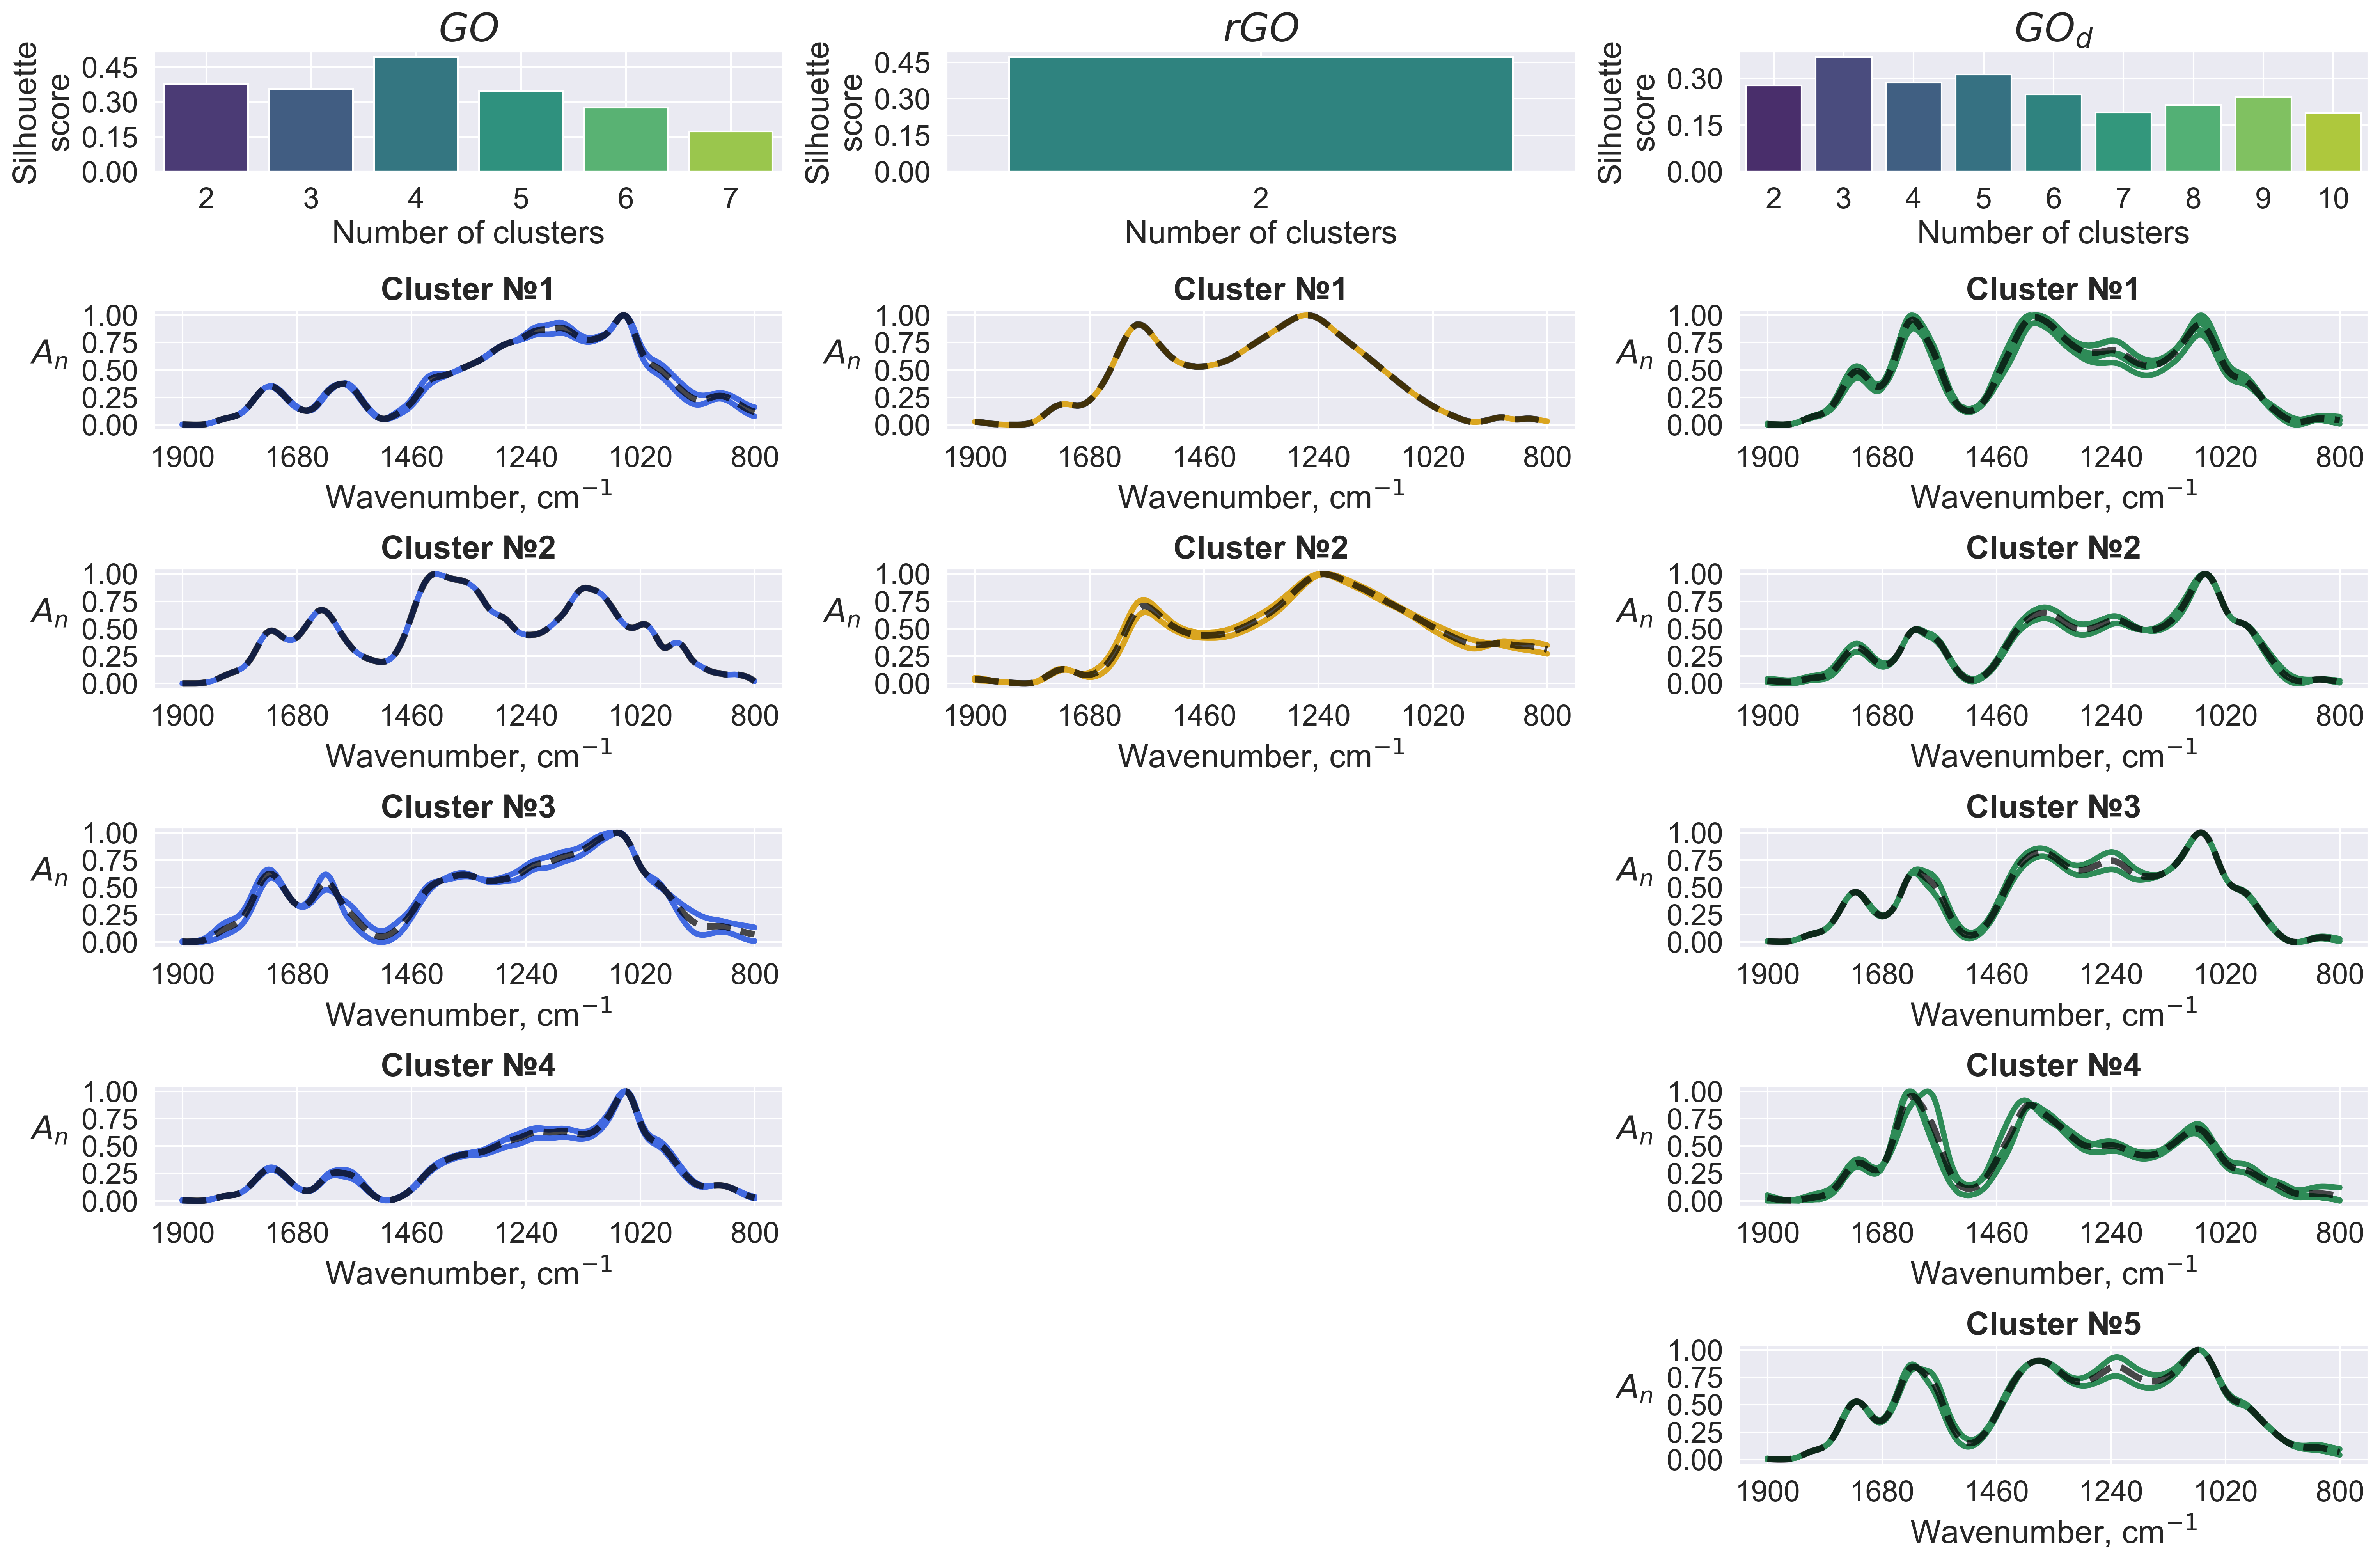

In [15]:
sns.set_theme()

max_clusters = max([d[3] for d in datasets])
fig_rows = 1 + max_clusters 

fig, axes = plt.subplots(fig_rows, 3, figsize=(20.5, 2.25 * fig_rows), dpi=300, constrained_layout=True)  # (15.5, 2.25)

for i, (label, dataset, color, n_clusters) in enumerate(datasets):
    analyzer = ClusterStructureAnalysis(metric='euclidean')

    analyzer.get_metrics_visualization(train_data=dataset, max_n_clusters=max_n_clusters, ax=axes[0, i])

    axes[0, i].set_title(f'{label}', fontsize=FONT_SIZE_TITLE+2)
    
    axes[0, i].set_xlabel(f'Number of clusters', fontsize=FONT_SIZE_XLABEL+2)
    axes[0, i].set_ylabel(f'Silhouette\nscore', fontsize=FONT_SIZE_YLABEL+2)

    axes[0, i].tick_params(axis='x', labelsize=FONT_SIZE_XTICKS+2)
    axes[0, i].tick_params(axis='y', labelsize=FONT_SIZE_YTICKS+2)
    
    axes[0, i].yaxis.set_major_locator(ticker.MultipleLocator(0.15))
    
    sub_axes = axes[1:n_clusters+1, i]
    analyzer.get_spectra_clusters_visualization(data=dataset, wavenumber=wavenumber, n_clusters=n_clusters, axes=sub_axes, color=color)

    for i, ax in enumerate(sub_axes):
        ax.set_title(f'Cluster №{i+1}', fontsize=FONT_SIZE_TITLE-2, fontweight='bold')
        
        ax.set_xlabel('Wavenumber, cm$^{-1}$', fontsize=FONT_SIZE_XLABEL+2)
        ax.set_ylabel('$A_{n}$', fontsize=FONT_SIZE_YLABEL+2)

        ax.tick_params(axis='x', labelsize=FONT_SIZE_XTICKS+2)
        ax.tick_params(axis='y', labelsize=FONT_SIZE_YTICKS+2)
        
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.25))

    predictions_lst.append(analyzer.train_data_predictions)

for i in range(3):  
    for j in range(datasets[i][3] + 1, fig_rows):  
        axes[j, i].axis("off")

plt.tight_layout()

plt.savefig('./../results/01a_as_timeseries/euclidean/adhoc_clustering_results.png', dpi=600)

plt.show()

## Metric — Dynamic Time Warping (DTW)

### Clustering & Visualization

In [16]:
n_datasets = 3  
max_n_clusters = 10  

datasets = [
    ('$ОГ$', go_data, 'RoyalBlue', 4),
    ('$вОГ$', rgo_data, 'Goldenrod', 2),
    ('$ОГ_{диализ}$', god_data, 'SeaGreen', 3)
]

predictions_lst = []

100%|█████████████████████████████████████████████| 9/9 [03:06<00:00, 20.68s/it]


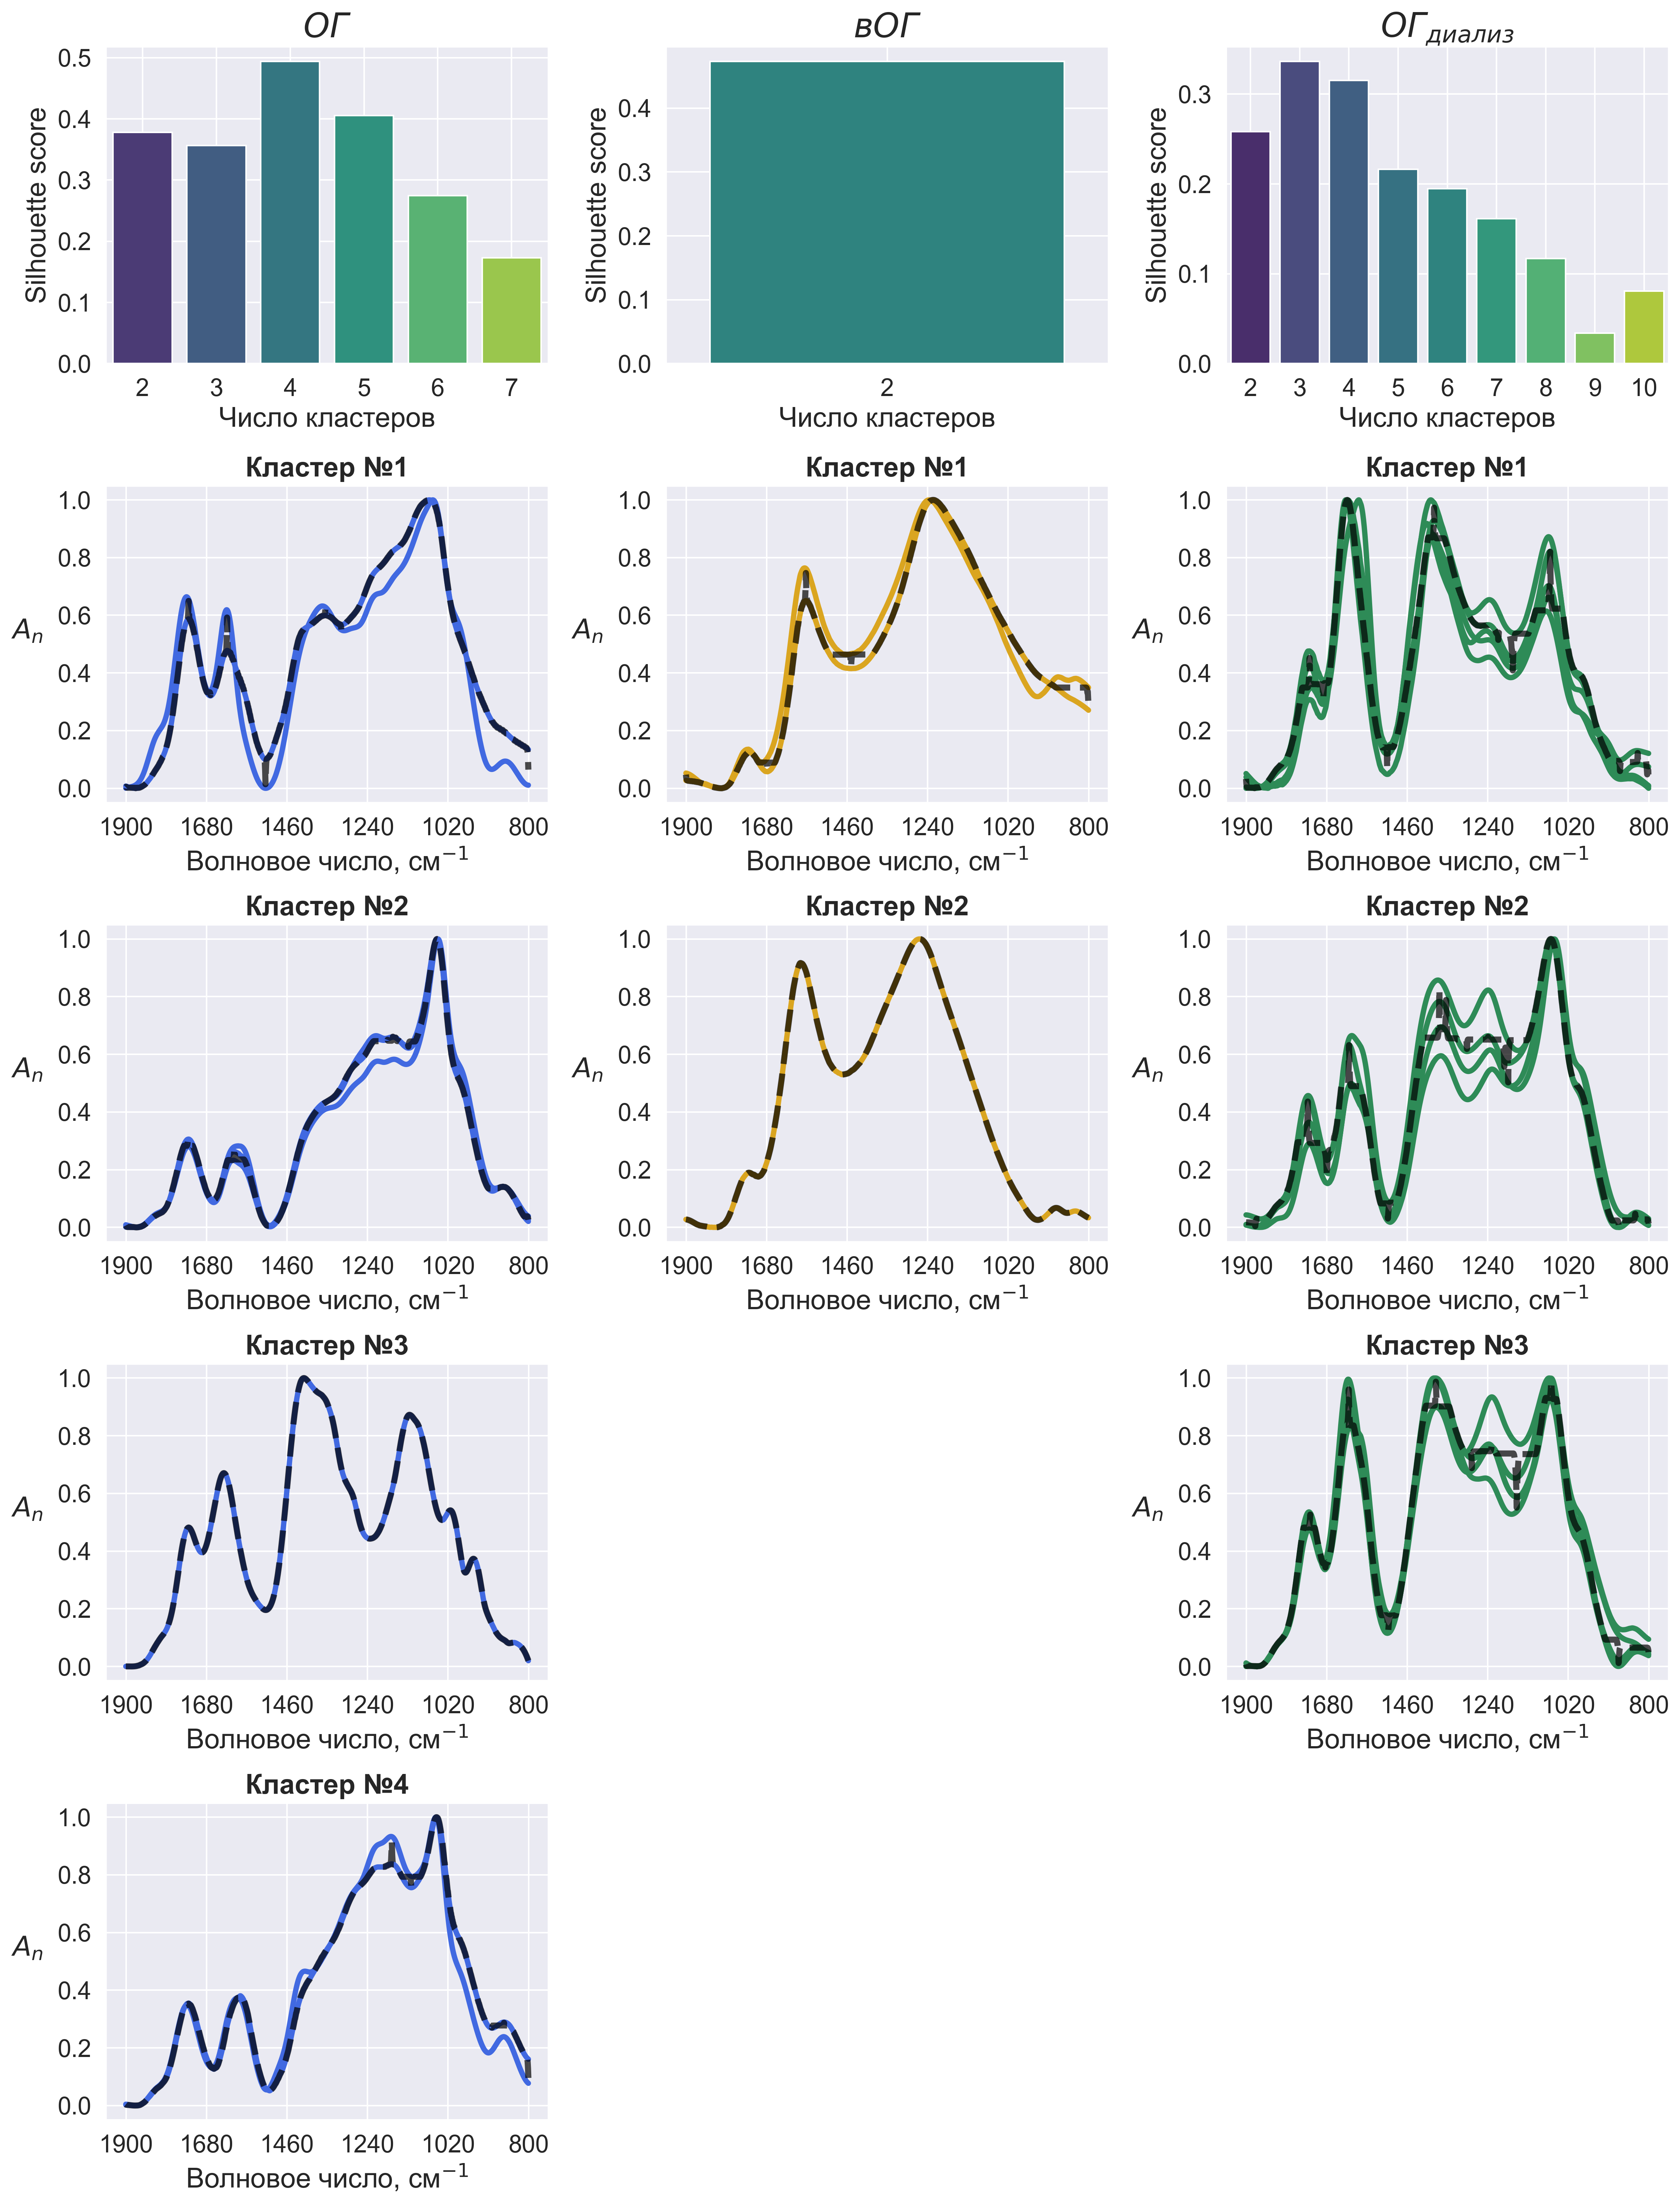

In [17]:
sns.set_theme()

max_clusters = max([d[3] for d in datasets])
fig_rows = 1 + max_clusters 

fig, axes = plt.subplots(fig_rows, 3, figsize=(15.5, 4.05 * fig_rows), dpi=300, constrained_layout=True)  

for i, (label, dataset, color, n_clusters) in enumerate(datasets):
    analyzer = ClusterStructureAnalysis(metric='dtw')

    analyzer.get_metrics_visualization(train_data=dataset, max_n_clusters=max_n_clusters, ax=axes[0, i])
    axes[0, i].set_title(f'{label}', fontsize=FONT_SIZE_TITLE)

    sub_axes = axes[1:n_clusters+1, i]
    analyzer.get_spectra_clusters_visualization(data=dataset, wavenumber=wavenumber, n_clusters=n_clusters, axes=sub_axes, color=color)

    predictions_lst.append(analyzer.train_data_predictions)

for i in range(3):  
    for j in range(datasets[i][3] + 1, fig_rows):  
        axes[j, i].axis("off")

plt.tight_layout()

plt.savefig('./../results/01a_as_timeseries/dtw/clustering_results.png', dpi=600)

plt.show()

### Analytics of results

In [18]:
results_df = pd.DataFrame()

for predictions_df in predictions_lst:
    tmp_description_prediction_df = pd.merge(
        left=predictions_df['Prediction'],
        right=samples_description[['Type', 'Description']],
        left_index=True,
        right_index=True
    )

    results_df = pd.concat([results_df, tmp_description_prediction_df], axis=0)

results_df = results_df[['Type', 'Description', 'Prediction']].sort_values(by=['Type', 'Prediction', 'Description'])

results_df

Type  \
12      $GO$   
1       $GO$   
9       $GO$   
11      $GO$   
8       $GO$   
2       $GO$   
3       $GO$   
13      $GO$   
30  $GO_{d}$   
24  $GO_{d}$   
25  $GO_{d}$   
28  $GO_{d}$   
29  $GO_{d}$   
26  $GO_{d}$   
27  $GO_{d}$   
18  $GO_{d}$   
17  $GO_{d}$   
31  $GO_{d}$   
20  $GO_{d}$   
22  $GO_{d}$   
19  $GO_{d}$   
23  $GO_{d}$   
6      $rGO$   
21     $rGO$   
10     $rGO$   

                                                                                  Description  \
12                                                                GO, USA, 0.1 г в 100 мл H2O   
1                                                                            MFGO, разб. 1:20   
9                                                        GO, RusGraphene, 1.00 г в 250 мл H2O   
11                                                       GO, RusGraphene, 1.00 г в 250 мл H2O   
8                                                          GO, RusGraphene, 2 г в 1000 мл H2O   
2                                                                   HGO, 0.0116 г в 25 мл H2O   
3                                                          GO, RusGraphene, 2 г в 1000 мл H2O   
13                                                         GO, RusGraphene, 2 г в 1000 мл H2O   
30                                Образец 13 после диализа 0.5 кДа, конд. 7 дней в ЭДТА 0.05М   
24                            Образец 9 после диализа 14 кДа 75 мм, конд. 7 дней в ЭДТА 0.05М   
25  Образец 9 после диализа 14 кДа 75 мм, конд. 7 дней в ЭДТА 0.05М (повторное использование)   
28                         Образец 9 после диализа при 25°С 14 кДа, конд. 7 дней в ЭДТА 0.05М   
29                         Образец 9 после диализа при 45°С 14 кДа, конд. 7 дней в ЭДТА 0.05М   
26                                              Образец 11 после диализа 2 дня, H2O (1.0 кДа)   
27                                      Образец 11 после диализа 5 дней, H2O, 75 мм (3.5 кДа)   
18        Образец 8 после диализа 7 дней, H2O, стакан 1 л, замена воды каждые 2 дня (0.5 кДа)   
17        Образец 8 после диализа 7 дней, H2O, стакан 1 л, замена воды каждые 2 дня (3.5 кДа)   
31                        Образец 30 после диализа 12 дней, 14 кДа, конд. 7 дней в ЭДТА 0.05М   
20                                Образец 8 после диализа 3.5 кДа, конд. 7 дней в ЭДТА 0.05 М   
22      Образец 8 после диализа 3.5 кДа, конд. 7 дней в ЭДТА 0.05 М (повторное использование)   
19                                     Образец 8 после диализа, конд. 7 дней в H2O (14.0 кДа)   
23                                  Образец 9 после диализа 14 кДа, конд. 7 дней в ЭДТА 0.05М   
6                                                         rGO, RusGraphene, 2 г в 1000 мл H2O   
21                                                    Образец 10 после диализа 3.5 кДа, конд.   
10                                                      rGO, RusGraphene, 0.20 г в 100 мл H2O   

    Prediction  
12           0  
1            0  
9            1  
11           1  
8            1  
2            2  
3            3  
13           3  
30           0  
24           0  
25           0  
28           0  
29           0  
26           1  
27           1  
18           1  
17           1  
31           2  
20           2  
22           2  
19           2  
23           2  
6            0  
21           0  
10           1

### Adhoc visualization

In [19]:
n_datasets = 3  
max_n_clusters = 10  

datasets = [
    ('$GO$', go_data, 'RoyalBlue', 4),
    ('$rGO$', rgo_data, 'Goldenrod', 2),
    ('$GO_{d}$', god_data, 'SeaGreen', 3)
]

predictions_lst = []

100%|█████████████████████████████████████████████| 9/9 [02:37<00:00, 17.48s/it]


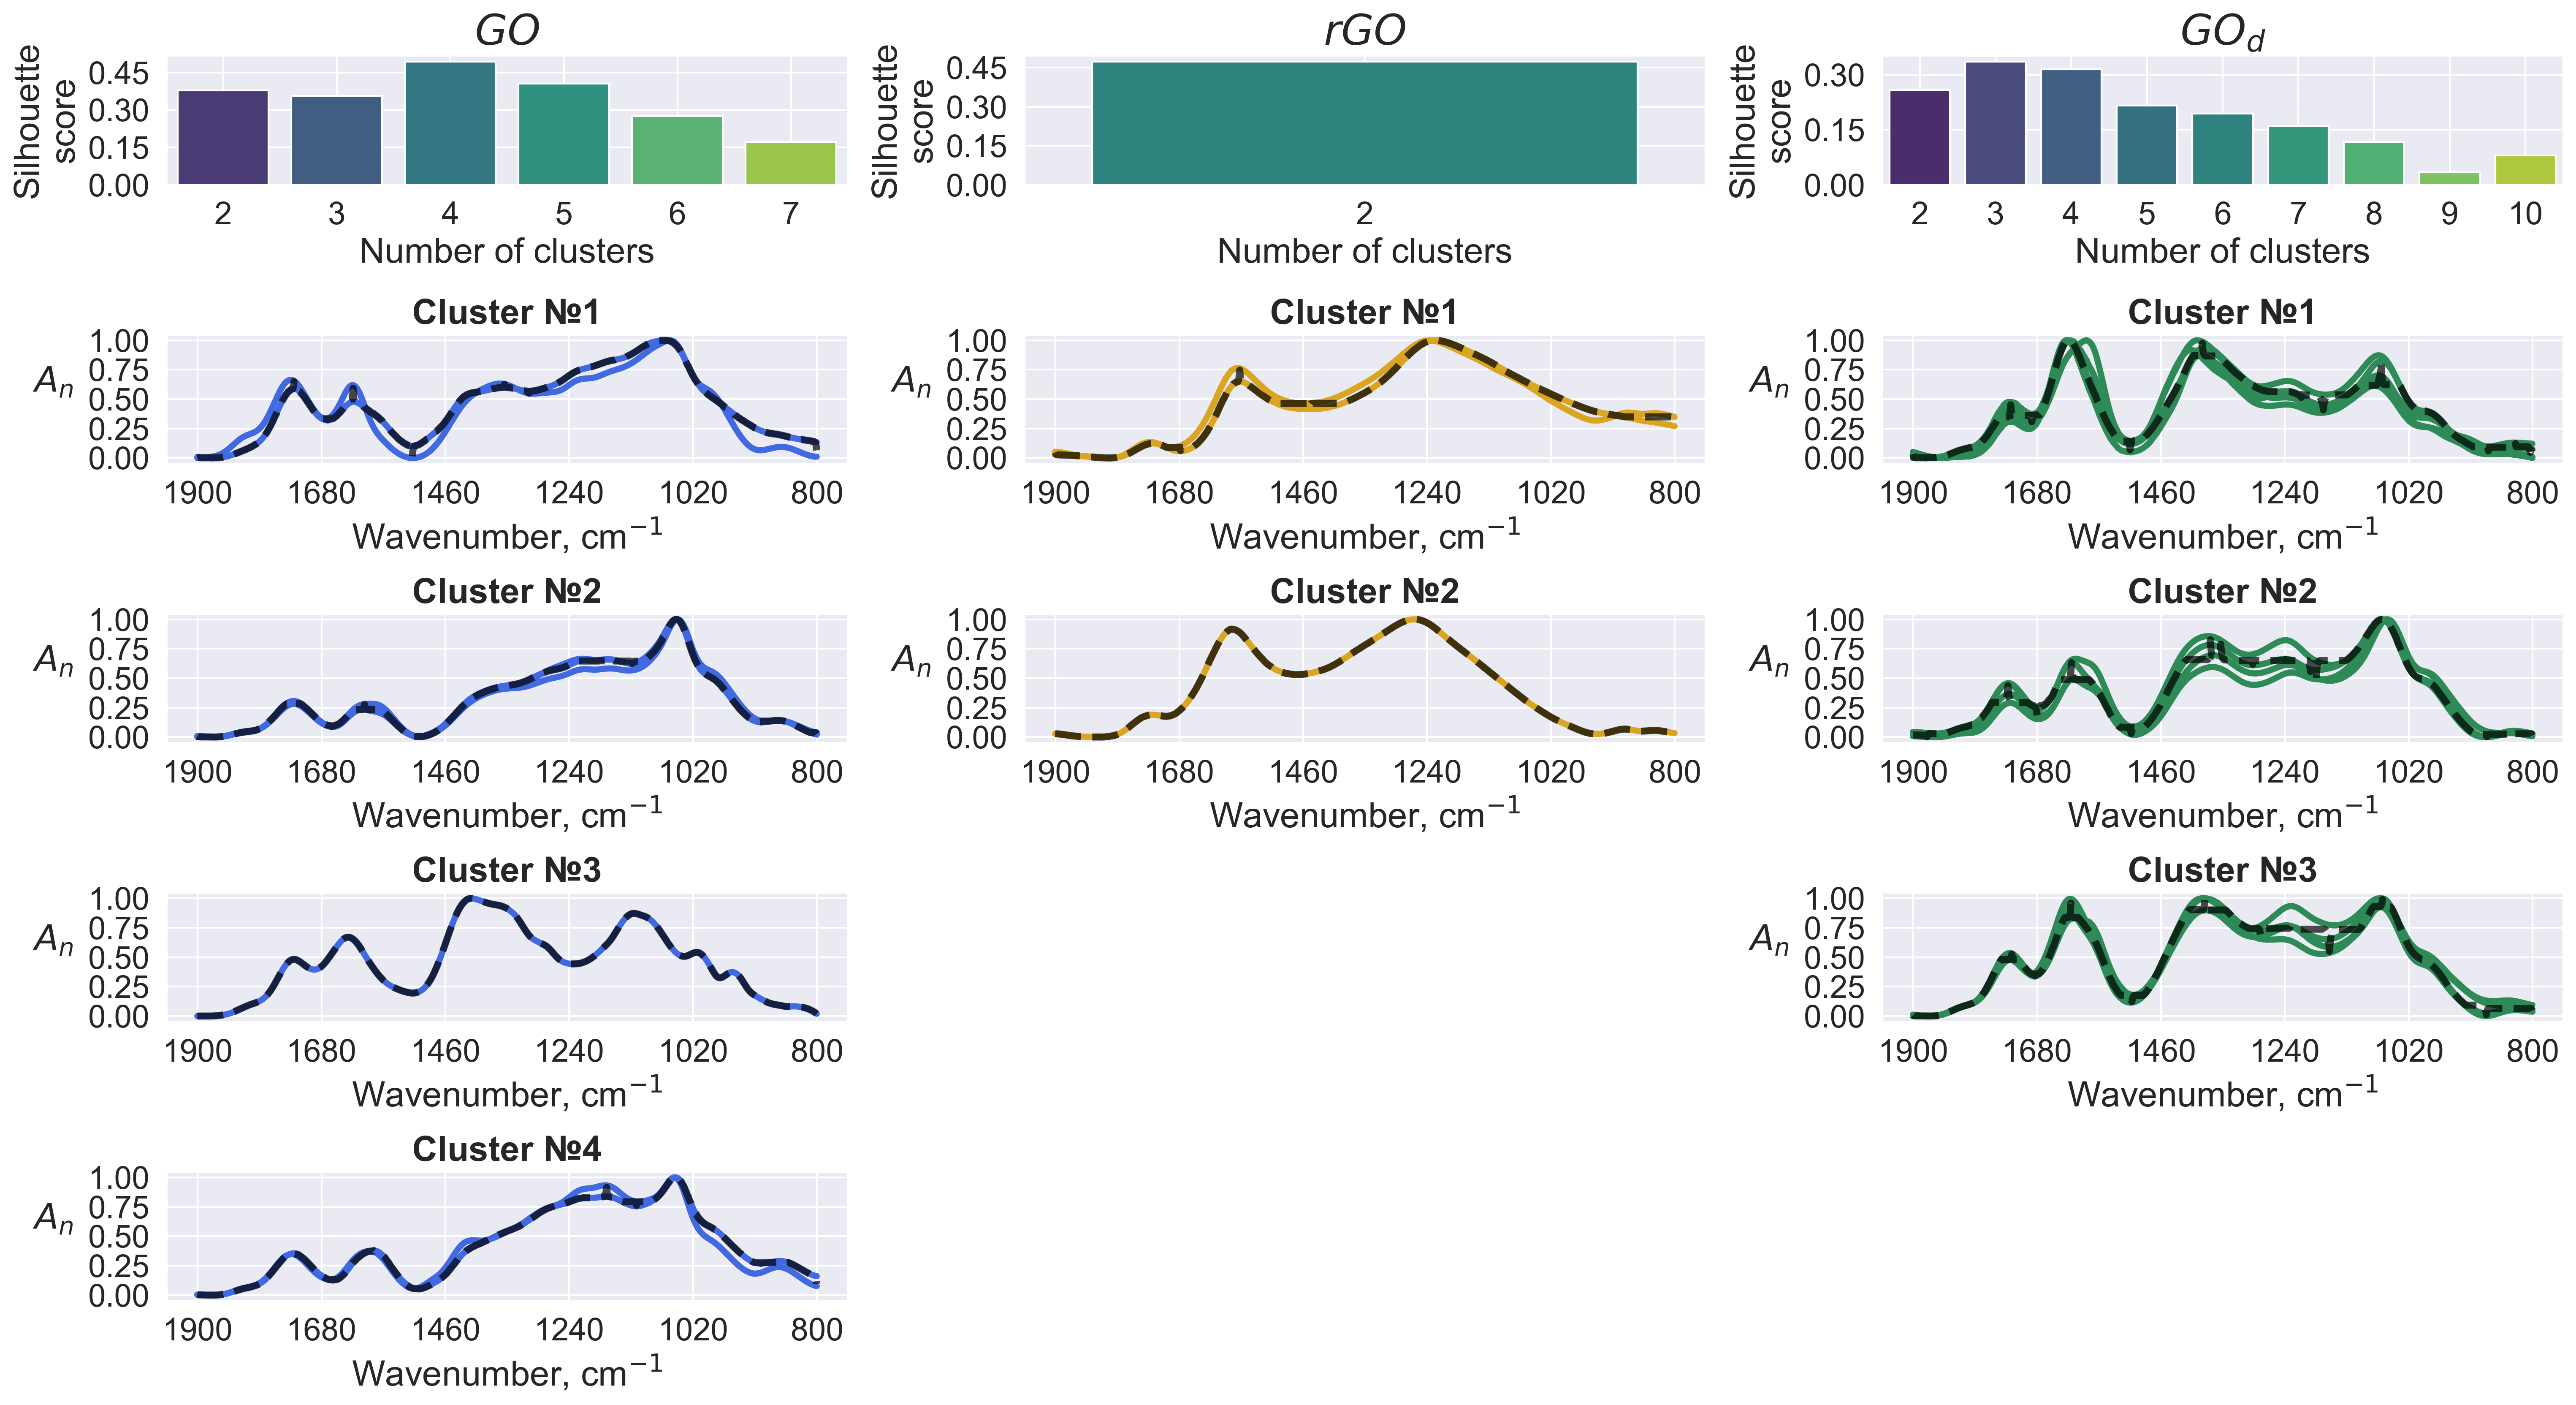

In [20]:
sns.set_theme()

max_clusters = max([d[3] for d in datasets])
fig_rows = 1 + max_clusters 

fig, axes = plt.subplots(fig_rows, 3, figsize=(20.5, 2.25 * fig_rows), dpi=300, constrained_layout=True)  # 2.25

for i, (label, dataset, color, n_clusters) in enumerate(datasets):
    analyzer = ClusterStructureAnalysis(metric='dtw')

    analyzer.get_metrics_visualization(train_data=dataset, max_n_clusters=max_n_clusters, ax=axes[0, i])

    axes[0, i].set_title(f'{label}', fontsize=FONT_SIZE_TITLE+2)
    
    axes[0, i].set_xlabel(f'Number of clusters', fontsize=FONT_SIZE_XLABEL+2)
    axes[0, i].set_ylabel(f'Silhouette\nscore', fontsize=FONT_SIZE_YLABEL+2)

    axes[0, i].tick_params(axis='x', labelsize=FONT_SIZE_XTICKS+2)
    axes[0, i].tick_params(axis='y', labelsize=FONT_SIZE_YTICKS+2)
    
    axes[0, i].yaxis.set_major_locator(ticker.MultipleLocator(0.15))
    
    sub_axes = axes[1:n_clusters+1, i]
    analyzer.get_spectra_clusters_visualization(data=dataset, wavenumber=wavenumber, n_clusters=n_clusters, axes=sub_axes, color=color)

    for i, ax in enumerate(sub_axes):
        ax.set_title(f'Cluster №{i+1}', fontsize=FONT_SIZE_TITLE-2, fontweight='bold')
        
        ax.set_xlabel('Wavenumber, cm$^{-1}$', fontsize=FONT_SIZE_XLABEL+2)
        ax.set_ylabel('$A_{n}$', fontsize=FONT_SIZE_YLABEL+2)

        ax.tick_params(axis='x', labelsize=FONT_SIZE_XTICKS+2)
        ax.tick_params(axis='y', labelsize=FONT_SIZE_YTICKS+2)
        
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.25))

    predictions_lst.append(analyzer.train_data_predictions)

for i in range(3):  
    for j in range(datasets[i][3] + 1, fig_rows):  
        axes[j, i].axis("off")

plt.tight_layout()

plt.savefig('./../results/01a_as_timeseries/dtw/adhoc_clustering_results.png', dpi=600)

plt.show()